<a href="https://colab.research.google.com/github/1337Rinz/AI_ML/blob/main/LeTuanKiet_NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.12.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
df = pd.read_csv('/content/drive/MyDrive/Báo cáo đồ án. /Đại học/Xử lý ngôn ngữ tự nhiên/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .
It contains the following 6 fields:



---


target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)


---



According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

s

In [19]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [20]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)


In [21]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

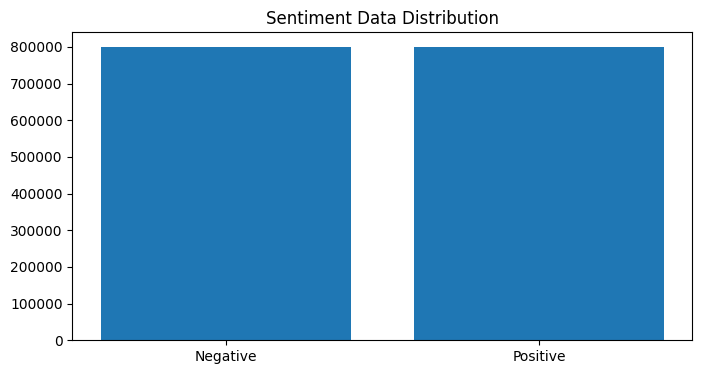

In [22]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [23]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
137342,Negative,"so i ordered this red tea, and it tastes awful..."
63696,Negative,@errantsock SAME! And no one in my family has ...
982101,Positive,"@Ericka05 noooo, I don't think so. Abl.abs mea..."
672247,Negative,In really deep for the calorie count tonight. ...
1084184,Positive,@StarlightGloom That is such a good idea. I th...
134428,Negative,Ya shelia just read that sux
1112656,Positive,@MariahCarey Hello Mariah! Have a great dau I...
835751,Positive,"I'm revising for my exams, and drinking my own..."
1337397,Positive,"@jodiluvsjordank yes, they are for phx I neve..."
293534,Negative,"I was shootin' hoops, and the ball hit the tip..."


In [24]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [25]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [26]:
# tien xu ly dataset
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words=2000, width=800, height=400, colormap='Blues').generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=2000, width=800, height=400, colormap='Blues').generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [27]:
# train test split

TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [28]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [29]:
train_data.head(10)


,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [30]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [33]:
labels = train_data.sentiment.unique().tolist()

In [34]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [35]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-08-14 18:56:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-14 18:56:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-14 18:56:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [36]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'

In [37]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [38]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [39]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [40]:
# training LSTM
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [73]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           87172500  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

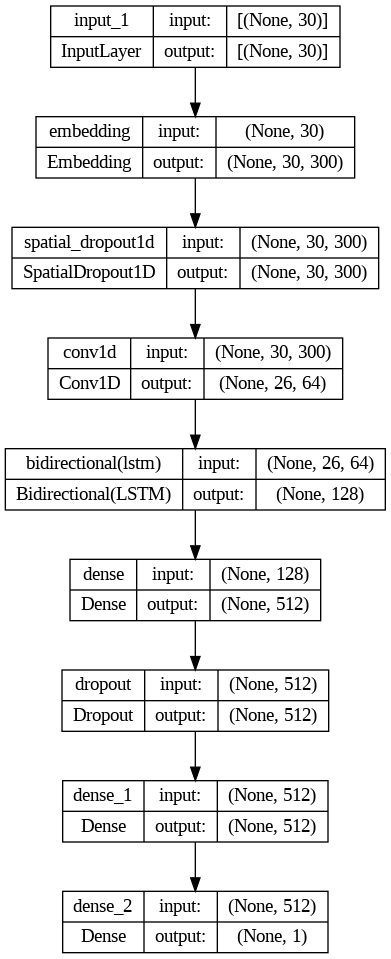

In [74]:
from tensorflow.keras.utils import plot_model

# Assuming you have 'model' loaded or defined
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [43]:
print("Train on GPU...") if tf.test.is_gpu_available() else print("Train on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Train on GPU...


In [44]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 167s 121ms/step - loss: 0.5199 - accuracy: 0.7390 - val_loss: 0.4830 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 149s 119ms/step - loss: 0.4884 - accuracy: 0.7619 - val_loss: 0.4729 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 148s 119ms/step - loss: 0.4780 - accuracy: 0.7688 - val_loss: 0.4673 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 147s 117ms/step - loss: 0.4714 - accuracy: 0.7727 - val_loss: 0.4653 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 147s 118ms/step - loss: 0.4666 - accuracy: 0.7755 - val_loss: 0.4637 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 148s 118ms/step - loss: 0.4638 - accuracy: 0.7776 - val_loss: 0.4598 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 7/10
1250/1250 [============

In [45]:
# save the .h5 file
model.save('save_model.h5')


In [46]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Replace 'model.h5' with the actual filename you used to save the model
model_path = os.path.join(current_dir, 'save_model.h5')

print("Model saved at:", model_path)


Model saved at: /content/save_model.h5


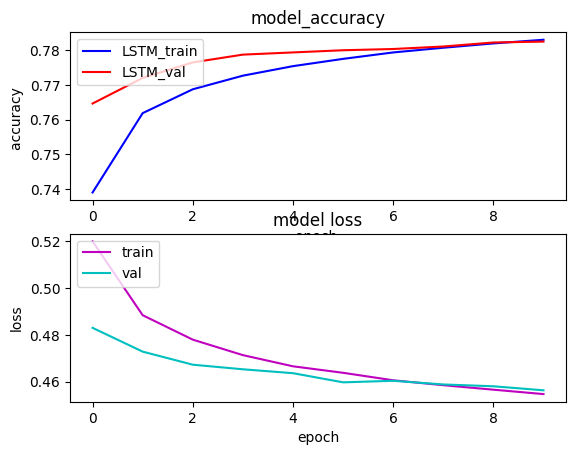

In [48]:
# Training Curve

s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model_accuracy')
at.set_ylabel('accuracy ')
at.set_xlabel('epoch ')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [49]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 64ms/step


In [50]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

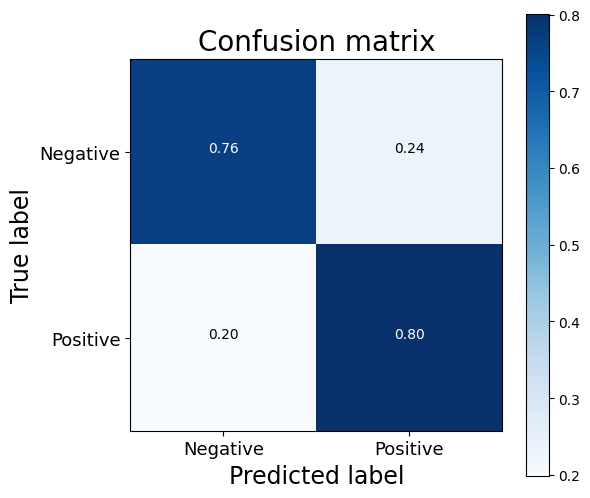

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.76      0.78    160542
    Positive       0.77      0.80      0.79    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [55]:
class_labels = test_data.sentiment.unique()
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=class_labels, title="Confusion matrix")
plt.show()

classification_rep = classification_report(test_data.sentiment.to_list(), y_pred_1d, target_names=class_labels)

print("Classification Report:")
print(classification_rep)

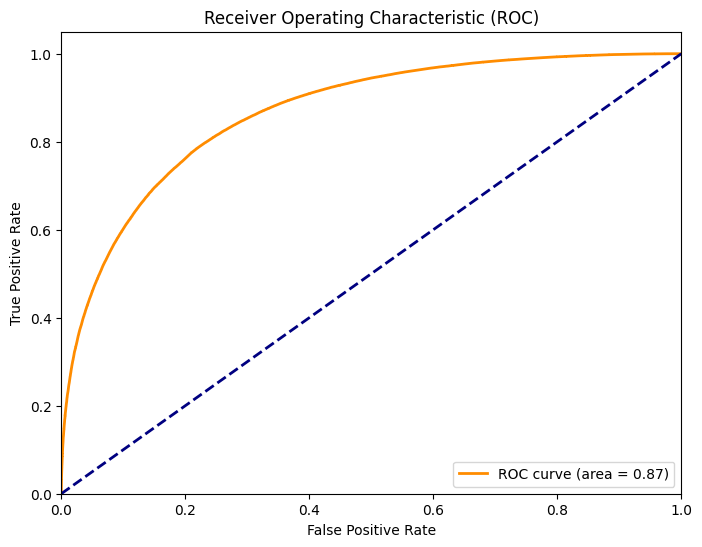

AUC: 0.8660272441455996


In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have y_test (true labels) and scores (model predictions) available
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


#Application


In [63]:
model_Trained = "/content/save_model.h5"

# Load the LSTM model
model = tf.keras.models.load_model(model_Trained)


# Preprocess the text input
text = "This is a great day"
text = preprocess(text)

# Convert the text input into a sequence of integers
int_sequence = tokenizer.texts_to_sequences([text])
int_sequence = pad_sequences(int_sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Get the predicted sentiment
prediction = model.predict(int_sequence)

# Decode the predicted sentiment
sentiment = decode_sentiment(prediction[0])

print(sentiment)
print(prediction[0])

1/1 [==============================] - 0s 487ms/step
Positive
[0.973585]
